# Assignment 2: Evaluating Classification Models
## Brandi Beals
## MSDS 422 DL-55

Use three binary explanatory variables relating to client banking history: default, housing, and loan. Predict the binary response variable: Has the client subscribed to a term deposit? Use all banking client observations with complete data for these study variables. Employ two classification methods: (1) logistic regression as described in Chapter 4 of the Géron (2017) textbook and (2) naïve Bayes classification. Evaluate these methods within a cross-validation design, using the area under the receiver operating characteristic (ROC) curve as an index of classification performance. Python scikit-learn should be your primary environment for conducting this research.

Scikit Learn documentation for this assignment:

http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB.score

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

http://scikit-learn.org/stable/modules/model_evaluation.html 

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

### Data preparation, exploration, visualization

In [82]:
# import base packages into the namespace for this program
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 1

# initial work with the smaller data set
bank = pd.read_csv('bank.csv', sep = ';')

# examine the shape of original input data
print(bank.shape)

(4521, 17)


In [3]:
# drop observations with missing data, if any
bank.dropna()

# examine the shape of input data after dropping missing data
print(bank.shape)

# there doesn't appear to be any missing data

(4521, 17)


In [5]:
# look at the list of column names, note that y is the response
list(bank.columns.values)

['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing',
 'loan',
 'contact',
 'day',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'response']

In [6]:
# look at the beginning of the DataFrame
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,response
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [64]:
bank.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


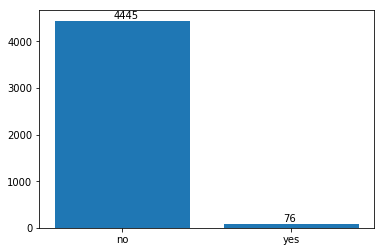

In [53]:
default = bank['default'].value_counts()
y_pos = np.arange(len(default))
plt.bar(y_pos, default)
plt.xticks(y_pos, default.index)

for i in range(len(default.index)):
    plt.text(x = y_pos[i]-0.05, y = default[i]+50, s = default[i])
    
# there are very few defaults

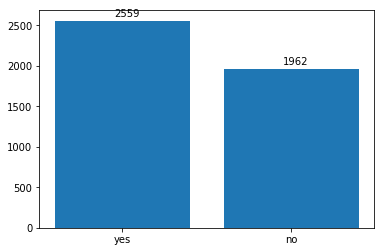

In [54]:
housing = bank['housing'].value_counts()
y_pos = np.arange(len(housing))
plt.bar(y_pos, housing)
plt.xticks(y_pos, housing.index)

for i in range(len(housing.index)):
    plt.text(x = y_pos[i]-0.05, y = housing[i]+50, s = housing[i])

# the mix is about even for those that do and do not own a home

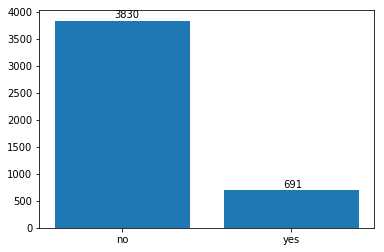

In [55]:
loan = bank['loan'].value_counts()
y_pos = np.arange(len(loan))
plt.bar(y_pos, loan)
plt.xticks(y_pos, loan.index)

for i in range(len(loan.index)):
    plt.text(x = y_pos[i]-0.05, y = loan[i]+50, s = loan[i])
    
# most people do not have loans

Text(0.5, 1.0, 'Age and Response Type')

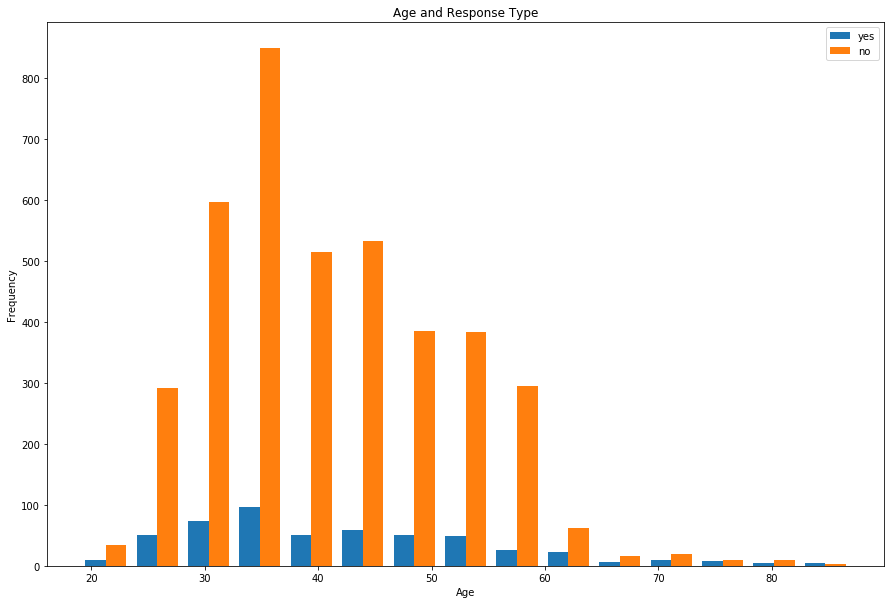

In [78]:
# age versus response
x1 = list(bank[bank['response'] == 'yes']['age'])
x2 = list(bank[bank['response'] == 'no']['age'])

plt.figure(figsize=(15,10))
plt.hist([x1, x2], label=['yes','no'], bins=15)
plt.legend()
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age and Response Type')

# very few people have a yes response and they vary across age groups

In [67]:
age_response = bank.groupby(['response', 'age'])['response'].count()

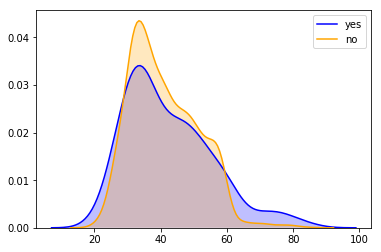

In [193]:
sns.kdeplot(bank[bank['response'] == 'yes']['age'], shade=True, color="blue")
sns.kdeplot(bank[bank['response'] == 'no']['age'], shade=True, color="orange")
plt.legend(['yes','no'])

# this density plot shows the two response types by age and percent
# there is a higher peak at age 35 for no respondents and at age 65 for yes respondents

In [88]:
# marital versus response
martial_response = bank.groupby(['response', 'marital'])['response'].count()
martial_response

response  marital 
no        divorced     451
          married     2520
          single      1029
yes       divorced      77
          married      277
          single       167
Name: response, dtype: int64

In [104]:
yes = martial_response['yes'].sum()
no = martial_response['no'].sum()
total = yes+no

In [123]:
div = bank[bank['marital'] == 'divorced'].groupby(['response'])['response'].count()
mar = bank[bank['marital'] == 'married'].groupby(['response'])['response'].count()
sin = bank[bank['marital'] == 'single'].groupby(['response'])['response'].count()

In [132]:
df = pd.DataFrame({'divorced':div, 'married':mar, 'single':sin})
df

,divorced,married,single
response,,,
no,451,2520,1029
yes,77,277,167


In [138]:
# From raw value to percentage
totals = [i+j+k for i,j,k in zip(df['divorced'], df['married'], df['single'])]
div = [i / j * 100 for i,j in zip(df['divorced'], totals)]
mar = [i / j * 100 for i,j in zip(df['married'], totals)]
sin = [i / j * 100 for i,j in zip(df['single'], totals)]

Text(0.5, 1.0, 'Distribution of Martial Status by Response')

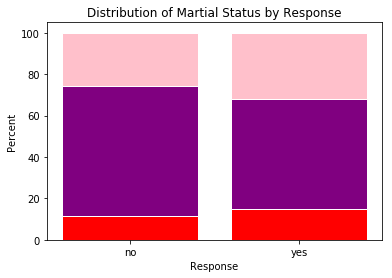

In [144]:
plt.bar([0,1], div, color='red', edgecolor='white')
plt.bar([0,1], mar, bottom=div, color='purple', edgecolor='white')
plt.bar([0,1], sin, bottom=[i+j for i,j in zip(div, mar)], color='pink', edgecolor='white')

plt.xticks([0,1], df.index)
plt.xlabel("Response")
plt.ylabel("Percent")
plt.title("Distribution of Martial Status by Response")

# this chart illustrates the different break down by marital status and response to determine if there might be a
# significant difference between the two

In [146]:
# education versus response
x1 = list(bank[bank['response'] == 'yes']['education'])
x2 = list(bank[bank['response'] == 'no']['education'])

Text(0.5, 1.0, 'Education and Response Type = Yes')

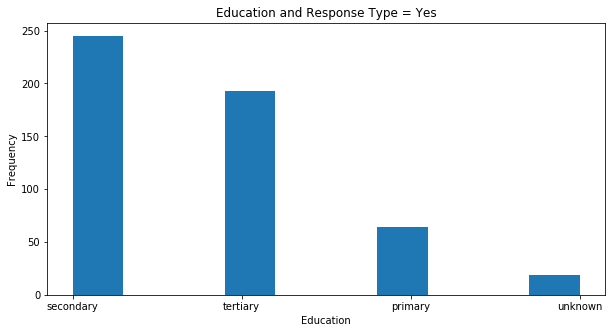

In [151]:
plt.figure(figsize=(10,5))
plt.hist(x1)
plt.xlabel('Education')
plt.ylabel('Frequency')
plt.title('Education and Response Type = Yes')

# the most likely yes respondents have a secondary education

Text(0.5, 1.0, 'Education and Response Type = No')

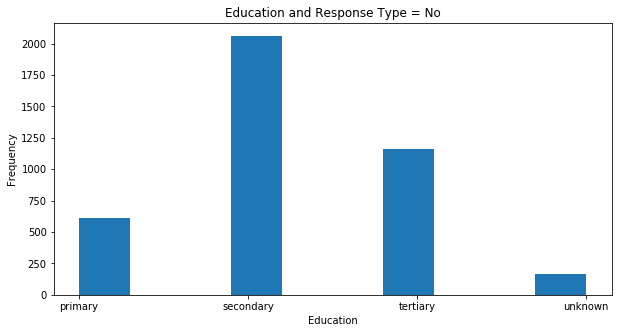

In [153]:
plt.figure(figsize=(10,5))
plt.hist(x2)
plt.xlabel('Education')
plt.ylabel('Frequency')
plt.title('Education and Response Type = No')

# but this fact is also true for no respondents

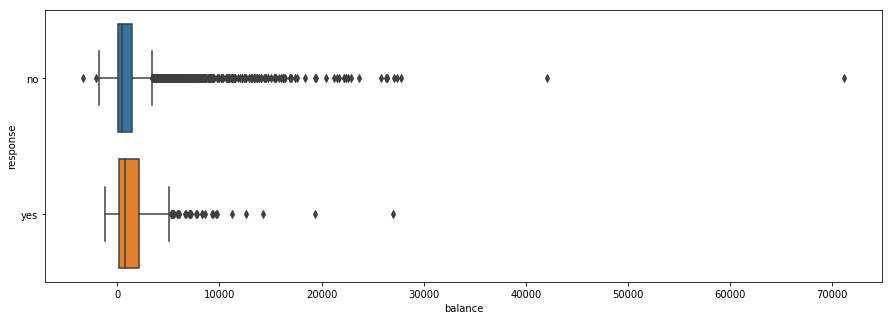

In [177]:
# balance versus response
plt.figure(figsize=(15,5))
sns.boxplot(x=bank["balance"], y=bank["response"])

# the means for yes and no respondents are about the same regardless of the account balance
# though, there are clear outliers for no respondents

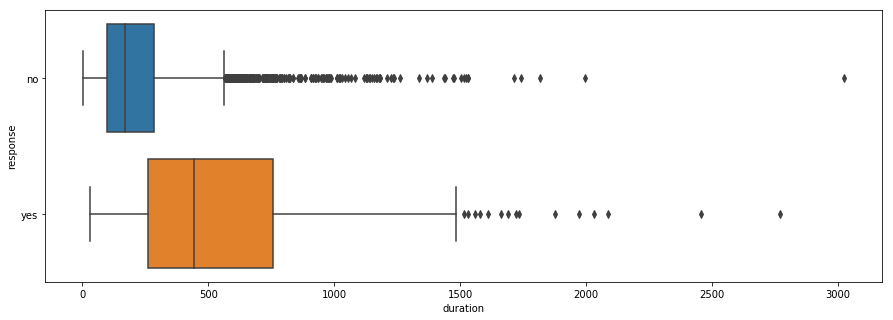

In [179]:
# duration versus response
plt.figure(figsize=(15,5))
sns.boxplot(x=bank["duration"], y=bank["response"])

# there appears to be a fairly signifant difference between yes and no responses when looking at call duration
# the longer a customer is on the phone may be a good sign

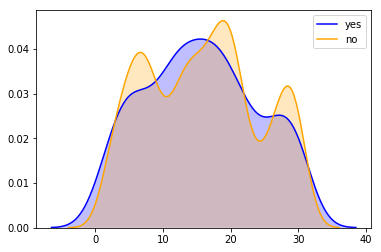

In [202]:
# day versus response
sns.kdeplot(bank[bank['response'] == 'yes']['day'], shade=True, color="blue")
sns.kdeplot(bank[bank['response'] == 'no']['day'], shade=True, color="orange")
plt.legend(['yes','no'])

# the 10th and 24th days of the month appear to be the least called when it comes to no responses
# the most yes responses occur around the 15th day of the month, which is when many people get paid

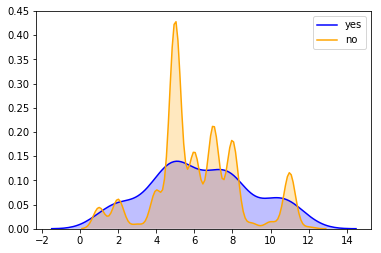

In [204]:
# month versus response
convert_month = {'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6,
                 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}
month = bank['month'].map(convert_month)

sns.kdeplot(month[bank['response'] == 'yes'], shade=True, color="blue")
sns.kdeplot(month[bank['response'] == 'no'], shade=True, color="orange")
plt.legend(['yes','no'])

# the no density plot is very bumpy, but peaks at the same month (May) as yes responses

Text(0.5, 1.0, 'Distribution of Contact Status by Response')

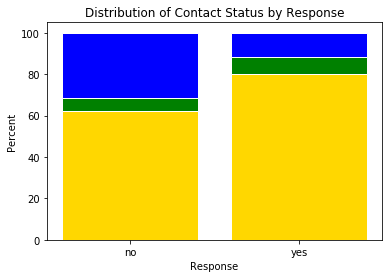

In [184]:
# contact versus response
cel = bank[bank['contact'] == 'cellular'].groupby(['response'])['response'].count()
tel = bank[bank['contact'] == 'telephone'].groupby(['response'])['response'].count()
unk = bank[bank['contact'] == 'unknown'].groupby(['response'])['response'].count()
df = pd.DataFrame({'cellular':cel, 'telephone':tel, 'unknown':unk})

# From raw value to percentage
totals = [i+j+k for i,j,k in zip(df['cellular'], df['telephone'], df['unknown'])]
cel = [i / j * 100 for i,j in zip(df['cellular'], totals)]
tel = [i / j * 100 for i,j in zip(df['telephone'], totals)]
unk = [i / j * 100 for i,j in zip(df['unknown'], totals)]

plt.bar([0,1], cel, color='gold', edgecolor='white')
plt.bar([0,1], tel, bottom=cel, color='green', edgecolor='white')
plt.bar([0,1], unk, bottom=[i+j for i,j in zip(cel, tel)], color='blue', edgecolor='white')

plt.xticks([0,1], df.index)
plt.xlabel("Response")
plt.ylabel("Percent")
plt.title("Distribution of Contact Status by Response")

# this bar chart shows more yes responses come from folks on cellphones

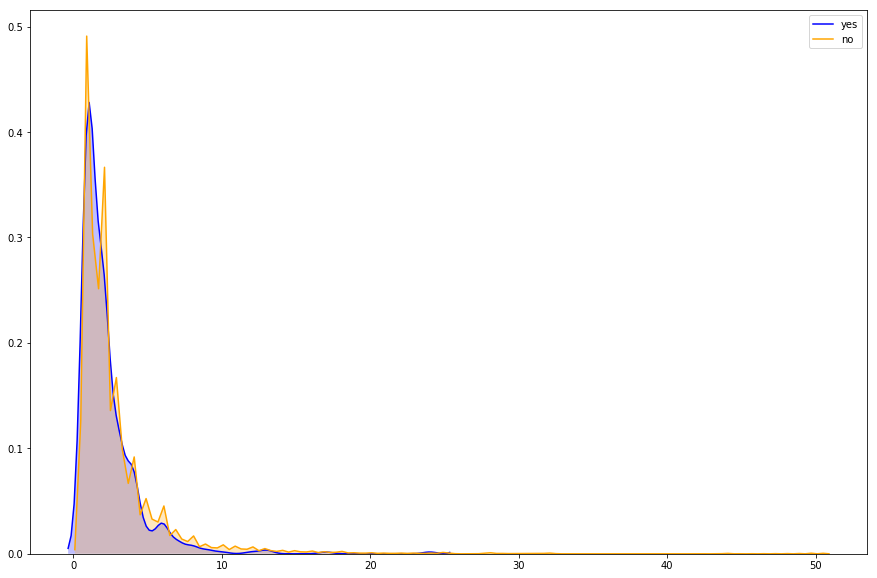

In [211]:
# campaign versus response
plt.figure(figsize=(15,10))
sns.kdeplot(bank[bank['response'] == 'yes']['campaign'], shade=True, color="blue")
sns.kdeplot(bank[bank['response'] == 'no']['campaign'], shade=True, color="orange")
plt.legend(['yes','no'])

# while the no response rate line is more jagged, both responses follow a similar pattern

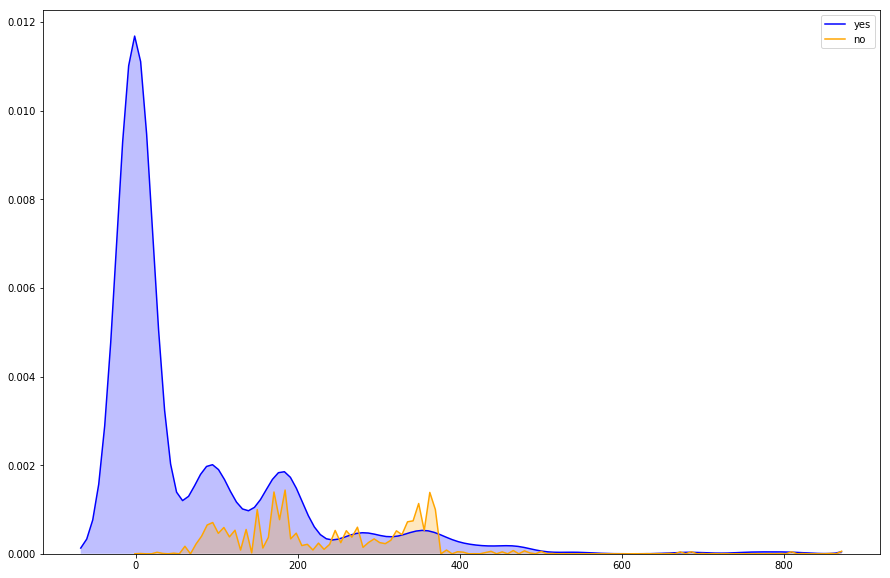

In [214]:
# pdays versus response
plt.figure(figsize=(15,10))
sns.kdeplot(bank[bank['response'] == 'yes']['pdays'], shade=True, color="blue")
sns.kdeplot(bank[bank['response'] == 'no']['pdays'], shade=True, color="orange")
plt.legend(['yes','no'])

# the yes response is very high around -1, 0, and 1, which means the customer was either never contacted, 
# contacted only just today, or contacted yesterday, respectively

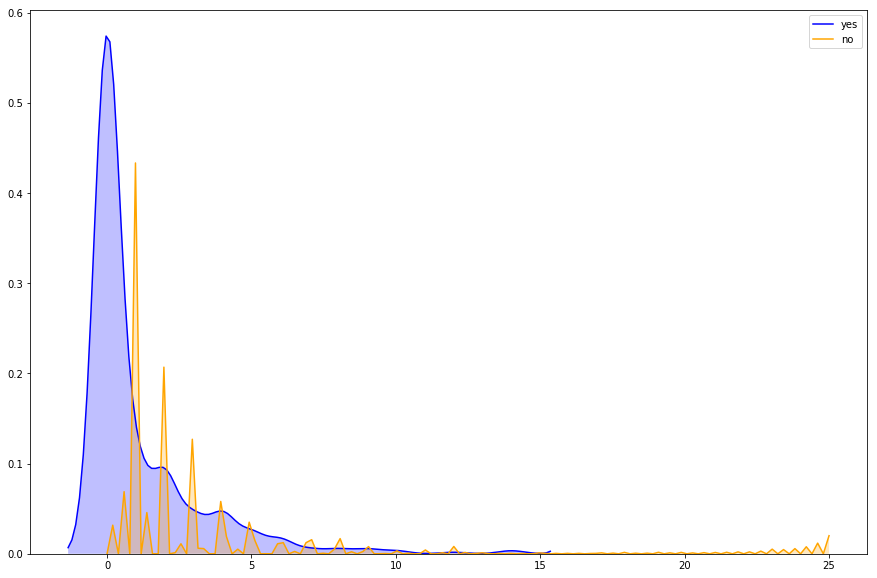

In [216]:
# previous versus response
plt.figure(figsize=(15,10))
sns.kdeplot(bank[bank['response'] == 'yes']['previous'], shade=True, color="blue")
sns.kdeplot(bank[bank['response'] == 'no']['previous'], shade=True, color="orange")
plt.legend(['yes','no'])

# very similar metric and response as the previous chart

Text(0.5, 1.0, 'Previous Outcome and Response Type')

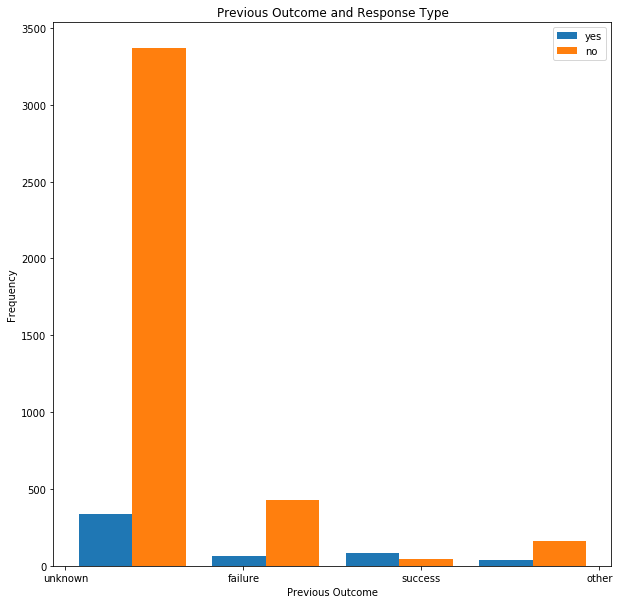

In [206]:
# poutcome versus response
x1 = list(bank[bank['response'] == 'yes']['poutcome'])
x2 = list(bank[bank['response'] == 'no']['poutcome'])

plt.figure(figsize=(10,10))
plt.hist([x1, x2], label=['yes','no'], bins=4)
plt.legend()
plt.xlabel('Previous Outcome')
plt.ylabel('Frequency')
plt.title('Previous Outcome and Response Type')

# not surprisingly, a previously succcessful outcome has an impact on a yes response

In [159]:
# mapping function to convert text no/yes to integer -1/1
convert_to_binary = {'no' : -1, 'yes' : 1}

# define binary variable for having credit in default
default = bank['default'].map(convert_to_binary)

# define binary variable for having a mortgage or housing loan
housing = bank['housing'].map(convert_to_binary)

# define binary variable for having a personal loan
loan = bank['loan'].map(convert_to_binary)

# define response variable to use in the model
response = bank['response'].map(convert_to_binary)

In [160]:
# default versus response
np.corrcoef(default,response)

array([[1.        , 0.00130265],
       [0.00130265, 1.        ]])

In [164]:
# housing versus response
np.corrcoef(housing,response)

array([[ 1.       , -0.1046834],
       [-0.1046834,  1.       ]])

In [163]:
# loan versus response
np.corrcoef(loan,response)

array([[ 1.        , -0.07051704],
       [-0.07051704,  1.        ]])

In [ ]:
# these correlations are done to simply show if these two variables are related and it doesn't appear that they are
# either positively or negatively

In [220]:
# mapping function to convert text no/yes to integer 0/1
convert_to_binary = {'no' : 0, 'yes' : 1}

# define binary variable for having credit in default
default = bank['default'].map(convert_to_binary)

# define binary variable for having a mortgage or housing loan
housing = bank['housing'].map(convert_to_binary)

# define binary variable for having a personal loan
loan = bank['loan'].map(convert_to_binary)

# define response variable to use in the model
response = bank['response'].map(convert_to_binary)

In [221]:
# gather three explanatory variables and response into a numpy array 
# here we use .T to obtain the transpose for the structure we want
model_data = np.array([np.array(default), np.array(housing), np.array(loan), 
    np.array(response)]).T

# examine the shape of model_data, which we will use in subsequent modeling
print(model_data.shape)

(4521, 4)


In [222]:
# understand the structure of the data
model_data

array([[0, 0, 0, 0],
       [0, 1, 1, 0],
       [0, 1, 0, 0],
       ...,
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 1, 1, 0]], dtype=int64)

### Review research design and modeling methods
Predict the binary response variable: Has the client subscribed to a term deposit? Use all banking client observations with complete data for these study variables. Employ two classification methods: (1) logistic regression as described in Chapter 4 of the Géron (2017) textbook and (2) naïve Bayes classification.

#### Logistic Regression

In [217]:
# import necessary packages
from sklearn.linear_model import LogisticRegression

In [229]:
bank[['age','duration','contact','pdays','poutcome']].head(10)

,age,duration,contact,pdays,poutcome
0,30,79,cellular,-1,unknown
1,33,220,cellular,339,failure
2,35,185,cellular,330,failure
3,30,199,unknown,-1,unknown
4,59,226,unknown,-1,unknown
5,35,141,cellular,176,failure
6,36,341,cellular,330,other
7,39,151,cellular,-1,unknown
8,41,57,unknown,-1,unknown
9,43,313,cellular,147,failure


In [230]:
X = bank[['age','duration','pdays']]
y = response

In [233]:
logreg = LogisticRegression(solver='lbfgs').fit(X, y)
logreg

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [255]:
log_score = logreg.predict(X)

#### Naive Bayes Classification

In [234]:
# import necessary packages
from sklearn.naive_bayes import BernoulliNB

In [236]:
nb = BernoulliNB().fit(X, y)
nb

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [266]:
nb_score = nb.predict(X)

### Review results, evaluate models
Evaluate these methods within a cross-validation design, using the area under the receiver operating characteristic (ROC) curve as an index of classification performance.

#### Cross-Validation

In [239]:
from sklearn.model_selection import cross_val_score

In [241]:
# cross validation on the Logistic Regression model
scores = cross_val_score(LogisticRegression(solver='lbfgs'), X, y, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

In [242]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
display_scores(rmse_scores)

Scores: [0.32551538 0.31901397 0.35198552 0.31200182 0.33918173 0.3292523
 0.33918173 0.32587527 0.33590454 0.33259505]
Mean: 0.3310507312494898
Standard deviation: 0.010792778930001865


In [243]:
# cross validation on the Naive Bayes model
scores_nb = cross_val_score(BernoulliNB(), X, y, scoring="neg_mean_squared_error", cv=10)
rmse_scores_nb = np.sqrt(-scores_nb)

In [244]:
def display_scores(scores_nb):
    print("Scores:", scores_nb)
    print("Mean:", scores_nb.mean())
    print("Standard deviation:", scores_nb.std())
display_scores(rmse_scores_nb)

Scores: [0.3420494  0.33918173 0.33918173 0.33918173 0.33918173 0.33918173
 0.33918173 0.33918173 0.33918173 0.33918173]
Mean: 0.33946849948342883
Standard deviation: 0.0008603003934650911


#### Receiver Operating Characteristic

In [259]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [261]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

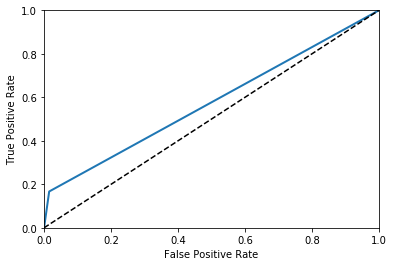

In [264]:
fpr, tpr, thresholds = roc_curve(y, log_score)
plot_roc_curve(fpr, tpr)
plt.show()

In [265]:
roc_auc_score(y, log_score)

0.5758682821497121

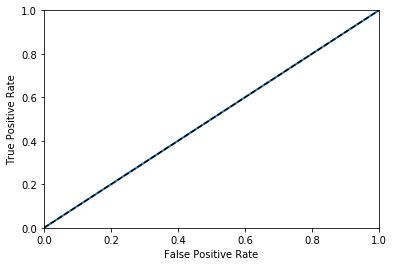

In [267]:
fpr, tpr, thresholds = roc_curve(y, nb_score)
plot_roc_curve(fpr, tpr)
plt.show()

In [268]:
roc_auc_score(y, nb_score)

0.5

### Exposition, problem description, and management recommendations
Regarding the management problem, imagine that you are advising the bank about machine learning methods to guide telephone marketing campaigns. Which of the two modeling methods would you recommend and why? And, given the results of your research, which group of banking clients appears to be the best target for direct marketing efforts (similar to those used with previous telephone campaigns)?

To begin, this process should be iterated over using a variety and combination of variables. During that process, some variables could be made into dummy variables, which could then be used in the classification models. Both the logistic regression and naive bayes models return a similar mean RMSE value, but the naive bayes classification model has a smaller standard deviation. Additionally, these models could be created using much more data, with the ability to reserve a test set for evaluating the models on data unseen.

There is clearly some work to be done on these models as indicated by the ROC curve, but the area under the curve for the logistic regression model is greater than 50% and thus does better than random. The same cannot be said for the naive bayes model. Thus, in this situation, the logistic regression model should be chosen. 